# Activity 08
## Tyler Barna

### Contents

 1. [Import Modules and Data](#import)
 2. [Visualizing Data](#data)  
 3. [Data](#data)  
     3.1 [Basic Linear Fit](#polyfit)  
     3.2 [MCMC Analysis (No Error)](#mcmcNoError)
     3.3 [MCMC Analysis (With Error)](#mcmcWithError)  

### 1. Import Modules and Data
<a id='import'></a>

In [23]:
import csv
import dis
import inspect
import os
import sys
import time

import astropy
import astroquery
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import pymc as mc
import random
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.io import ascii
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.timeseries import TimeSeries
from astropy.visualization import time_support
time_support()
from astropy.visualization import quantity_support
quantity_support()

from IPython.display import display_html
from IPython.display import Image

from numpy import interp

from pymc import Model, Normal, Gamma, find_MAP

from scipy import integrate
from scipy import linalg as la
from scipy import optimize

from scipy.stats import beta
from scipy.stats import betabinom
from scipy.stats import binom
from scipy.stats import gamma
from scipy.stats import invgamma
from scipy.stats import multivariate_normal as mvn
from scipy.stats import nbinom
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import t
from scipy.stats import uniform

from sklearn.linear_model import LinearRegression as linreg
from sklearn import preprocessing as pp

%matplotlib inline

## set seed for reproducibility
random.seed(5731)

## import data
df = pd.read_csv('cepheids.csv')
display(df.describe())

,MV,MV_err,LogP,LogP_err
count,203.000000,203.000000,203.000000,203.000000
mean,-3.559606,0.096749,0.797635,0.031084
std,0.799984,0.032976,0.274683,0.020820
min,-6.080000,0.080000,-0.040000,0.020000
25%,-4.030000,0.090000,0.615000,0.020000
50%,-3.580000,0.090000,0.780000,0.020000
75%,-3.170000,0.100000,0.970000,0.020000
max,0.250000,0.460000,1.620000,0.070000


### 2. Visualizing Data
<a id='data'></a>

Let's visualize the data to see what we're working with.

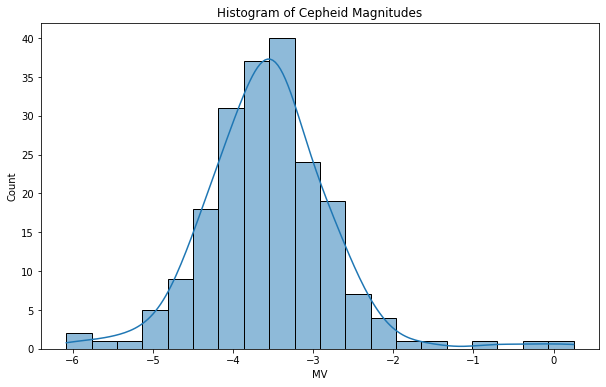

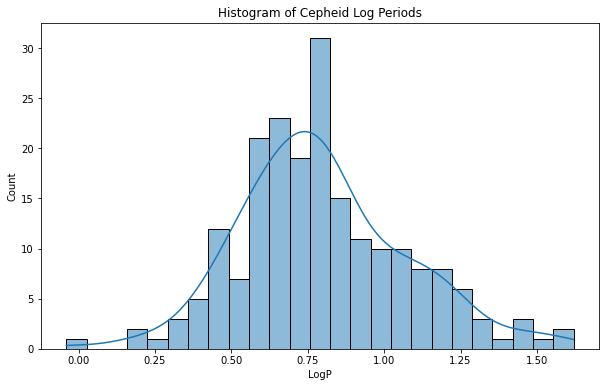

In [7]:
## plot histogram of magnitude with errors
fig, ax = plt.subplots(figsize=(10,6), facecolor='white')
sns.histplot(data=df, x='MV', kde=True, bins=20, ax=ax)
ax.set_title('Histogram of Cepheid Magnitudes')
plt.show();

## plot histogram of log period with errors
fig, ax = plt.subplots(figsize=(10,6), facecolor='white')
sns.histplot(data=df, x='LogP', kde=True, bins=25, ax=ax)
ax.set_title('Histogram of Cepheid Log Periods')
plt.show();

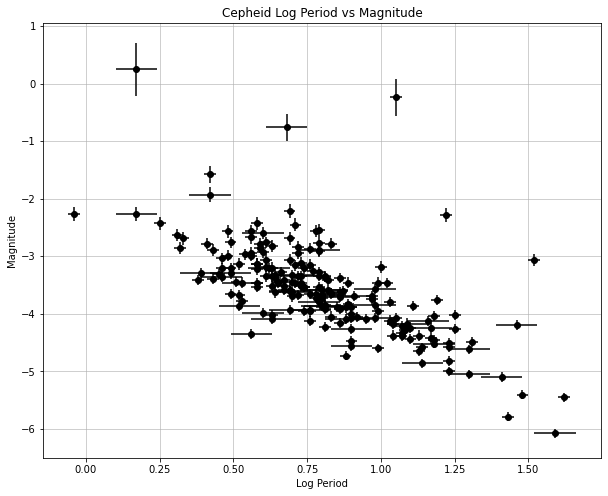

In [14]:
## plot the log period vs magnitude with errors for both
fig, ax = plt.subplots(figsize=(10,8), facecolor='white')
ax.errorbar(df['LogP'], df['MV'], xerr=df['LogP_err'], yerr=df['MV_err'], fmt='o', color='black')
ax.set_xlabel('Log Period')
ax.set_ylabel('Magnitude')
ax.grid(alpha=0.75)
ax.set_title('Cepheid Log Period vs Magnitude')
plt.show();

### 3. Analysis
<a id='analysis'></a>

#### 3.1 Basic Linear Fit
<a id='polyfit'></a>

Before performing the linear regression with PyMC, let's try the naive approach of fitting a line to the data. We can do this with the `np.polyfit` function. This function takes the x and y data, and the order of the polynomial to fit. We'll use a first order polynomial, which is a line.

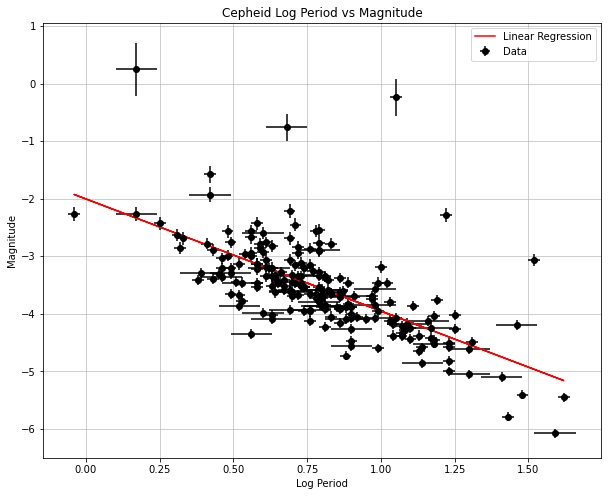

In [16]:
## fit the data with a linear regression with np.polyfit
m, b = np.polyfit(df['LogP'], df['MV'], 1)
estimated_MV = m*df['LogP'] + b

## plot the log period vs magnitude with errors for both
fig, ax = plt.subplots(figsize=(10,8), facecolor='white')
ax.errorbar(df['LogP'], df['MV'], xerr=df['LogP_err'], yerr=df['MV_err'], fmt='o', color='black', label='Data')

## now plot the estimated magnitude over top of it
ax.plot(df['LogP'], estimated_MV, color='red', label='Linear Regression')

## styling
ax.set_xlabel('Log Period')
ax.set_ylabel('Magnitude')
ax.grid(alpha=0.75)
ax.set_title('Cepheid Log Period vs Magnitude')
ax.legend()
plt.show();

We can compare this to the results of the mcmc analysis later.

#### 3.2 MCMC Analysis (No Error)
<a id='mcmcNoError'></a>

Now, I'll follow the steps outlined in the introductory file to perform the MCMC analysis. In this case, y will be the MV, and x will be LogP (there is only one x in our case)

In [21]:
x = df['LogP']
x_err = df['LogP_err']
y = df['MV']
y_err = df['MV_err']
basic_model = Model()
with basic_model:
    ## priors for unknown model parameters
    beta = Normal('beta',mu=0,tau=1./10, shape=2)
    precision = Gamma('precision', alpha=1, beta=1)
    
    mu = beta[0] + beta[1]*x
    Y_obs = Normal('Y_obs', mu=mu, tau=precision, observed=y)

#### 3.3 MCMC Analysis (With Error)
<a id='mcmcWithError'></a>